## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

## Extracting data from csv files

In [2]:
DATA_PATH = os.getcwd()+ '/data/'
IMAGES_PATH = os.getcwd()+ '/images/'

training_name = '6th_training'

TOTAL_EPISODES = 1000
AVERAGE_EPISODES_COUNT = 40

def read_data(path):
    df = pd.read_csv(path)
    data = df.to_numpy().reshape((len(df),))
    return data
    
rewards = read_data(DATA_PATH + training_name + '_rewards.csv')
steps = read_data(DATA_PATH + training_name + '_steps.csv')
episodic_rewards = read_data(DATA_PATH + training_name + '_episodic_rewards.csv')
average_episodic_rewards = read_data(DATA_PATH + training_name + '_average_episodic_rewards.csv')


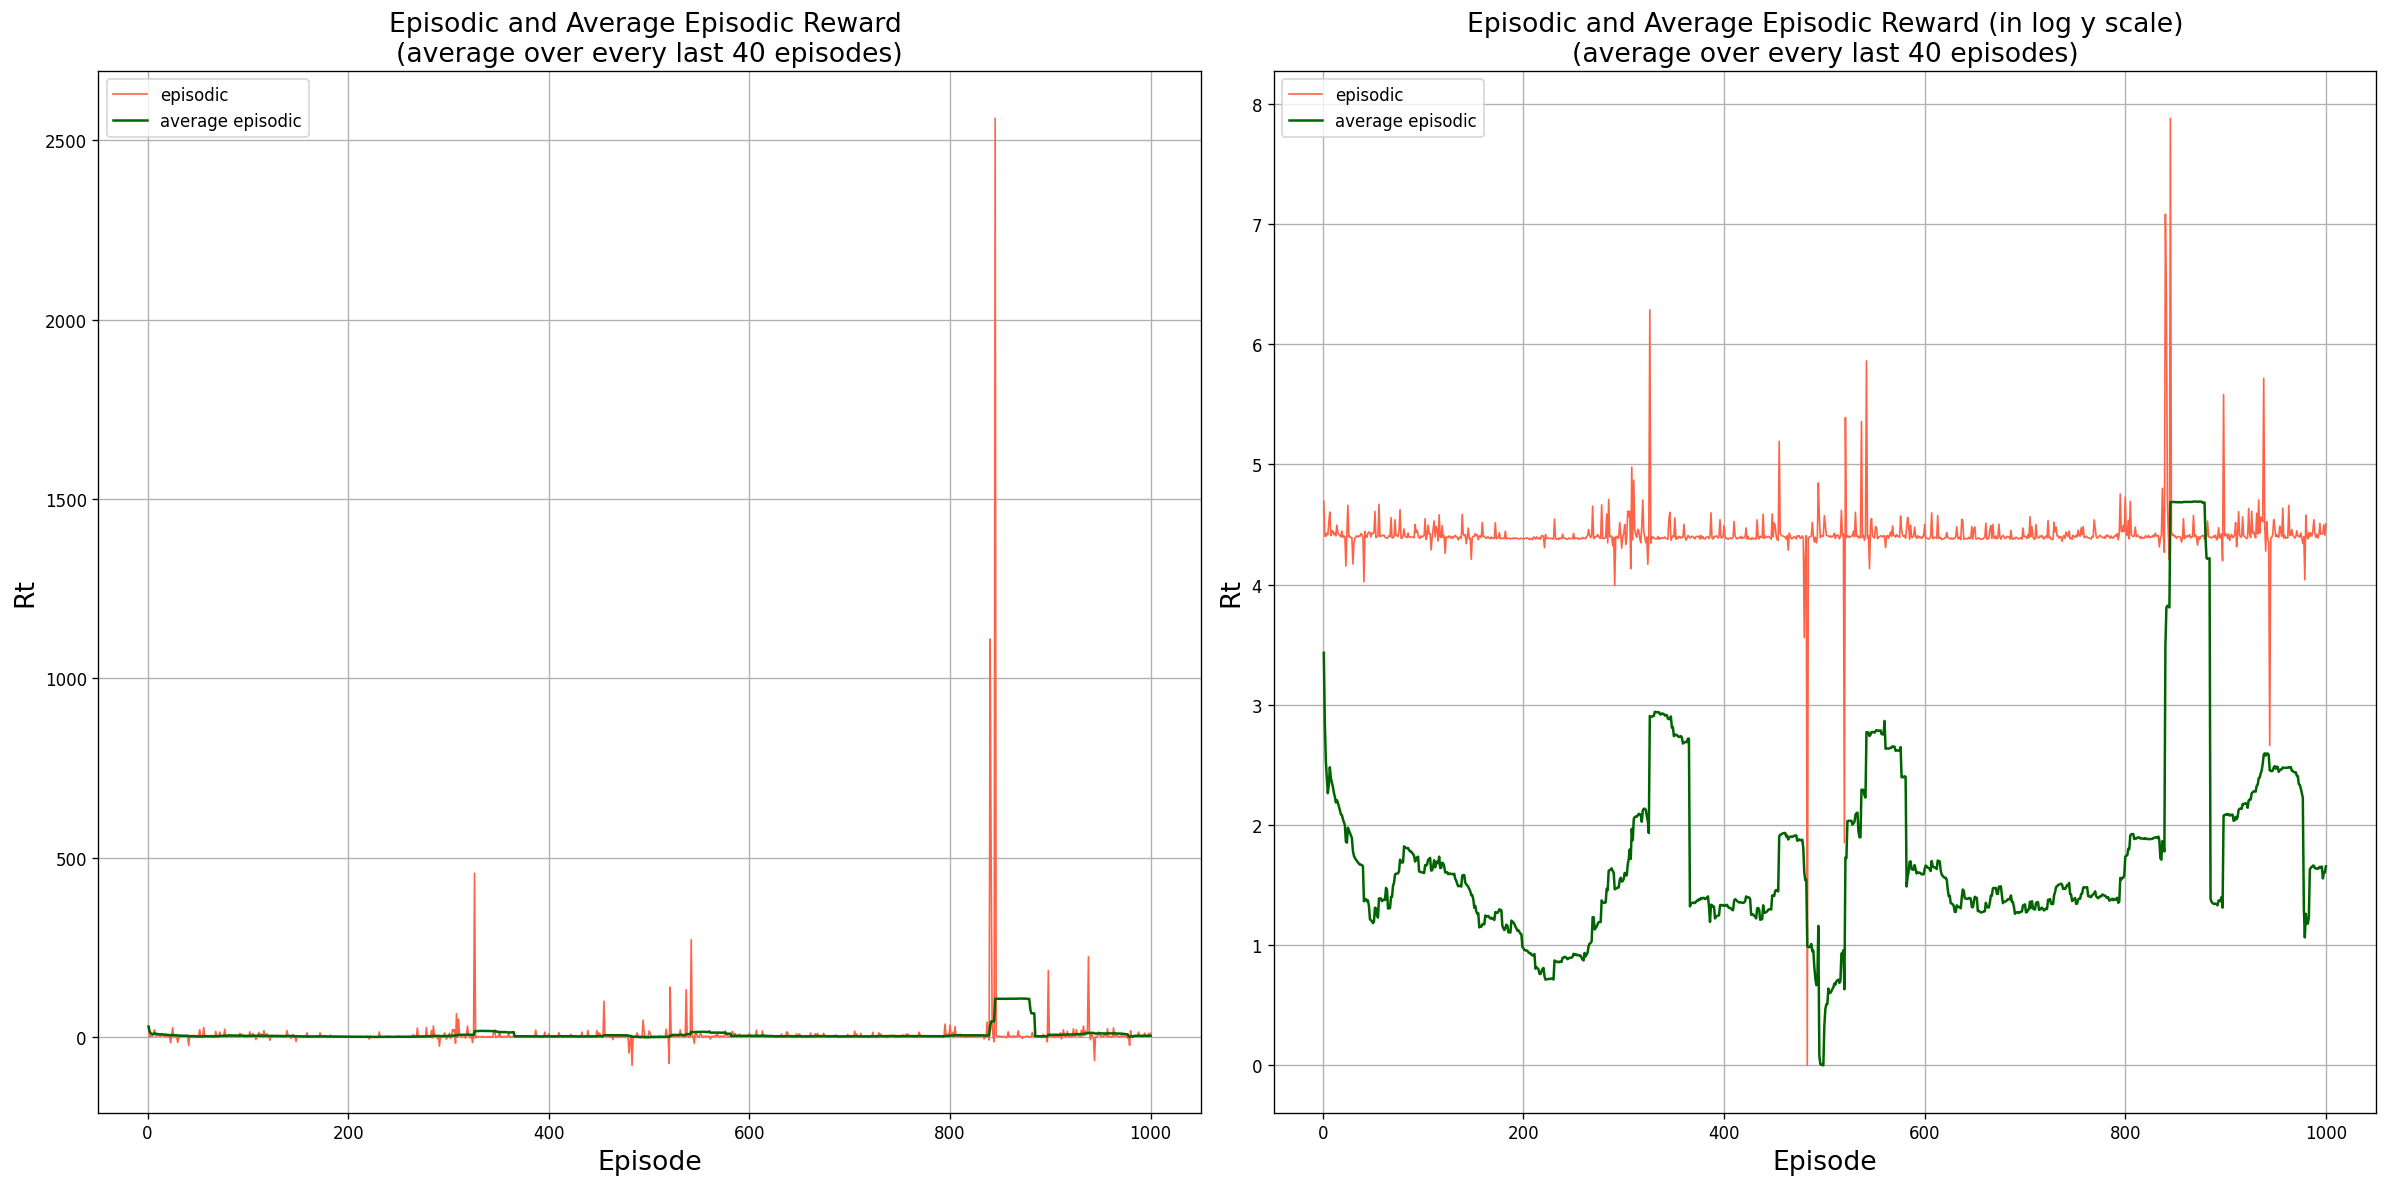

In [3]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (20,10), dpi = 120)
ax = axes.ravel()

ax[0].plot(np.arange(1,episodic_rewards.shape[0]+1), episodic_rewards, color='tomato', linewidth=1.0, label='episodic')
ax[0].plot(np.arange(1,average_episodic_rewards.shape[0]+1), average_episodic_rewards, color='darkgreen', linewidth=1.5, label='average episodic')
ax[0].grid()
ax[0].set_xlabel('Episode', fontsize=16)
ax[0].set_ylabel('Rt', fontsize=16)
ax[0].set_title('Episodic and Average Episodic Reward \n(average over every last {} episodes)'.format(AVERAGE_EPISODES_COUNT), fontsize=16)
ax[0].legend(loc='upper left')

ax[1].plot(np.arange(1,episodic_rewards.shape[0]+1), np.log(1+abs(min(episodic_rewards))+episodic_rewards), color='tomato', linewidth=1.0, label='episodic')
ax[1].plot(np.arange(1,average_episodic_rewards.shape[0]+1), np.log(1+abs(min(average_episodic_rewards))+average_episodic_rewards), color='darkgreen', linewidth=1.5, label='average episodic')
ax[1].grid()
ax[1].set_xlabel('Episode', fontsize=16)
ax[1].set_ylabel('Rt', fontsize=16)
ax[1].set_title('Episodic and Average Episodic Reward (in log y scale)\n(average over every last {} episodes)'.format(AVERAGE_EPISODES_COUNT), fontsize=16)
ax[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

fig.savefig(IMAGES_PATH + training_name + '_episodic_and_average_rewards', facecolor = 'white', bbox_inches='tight')

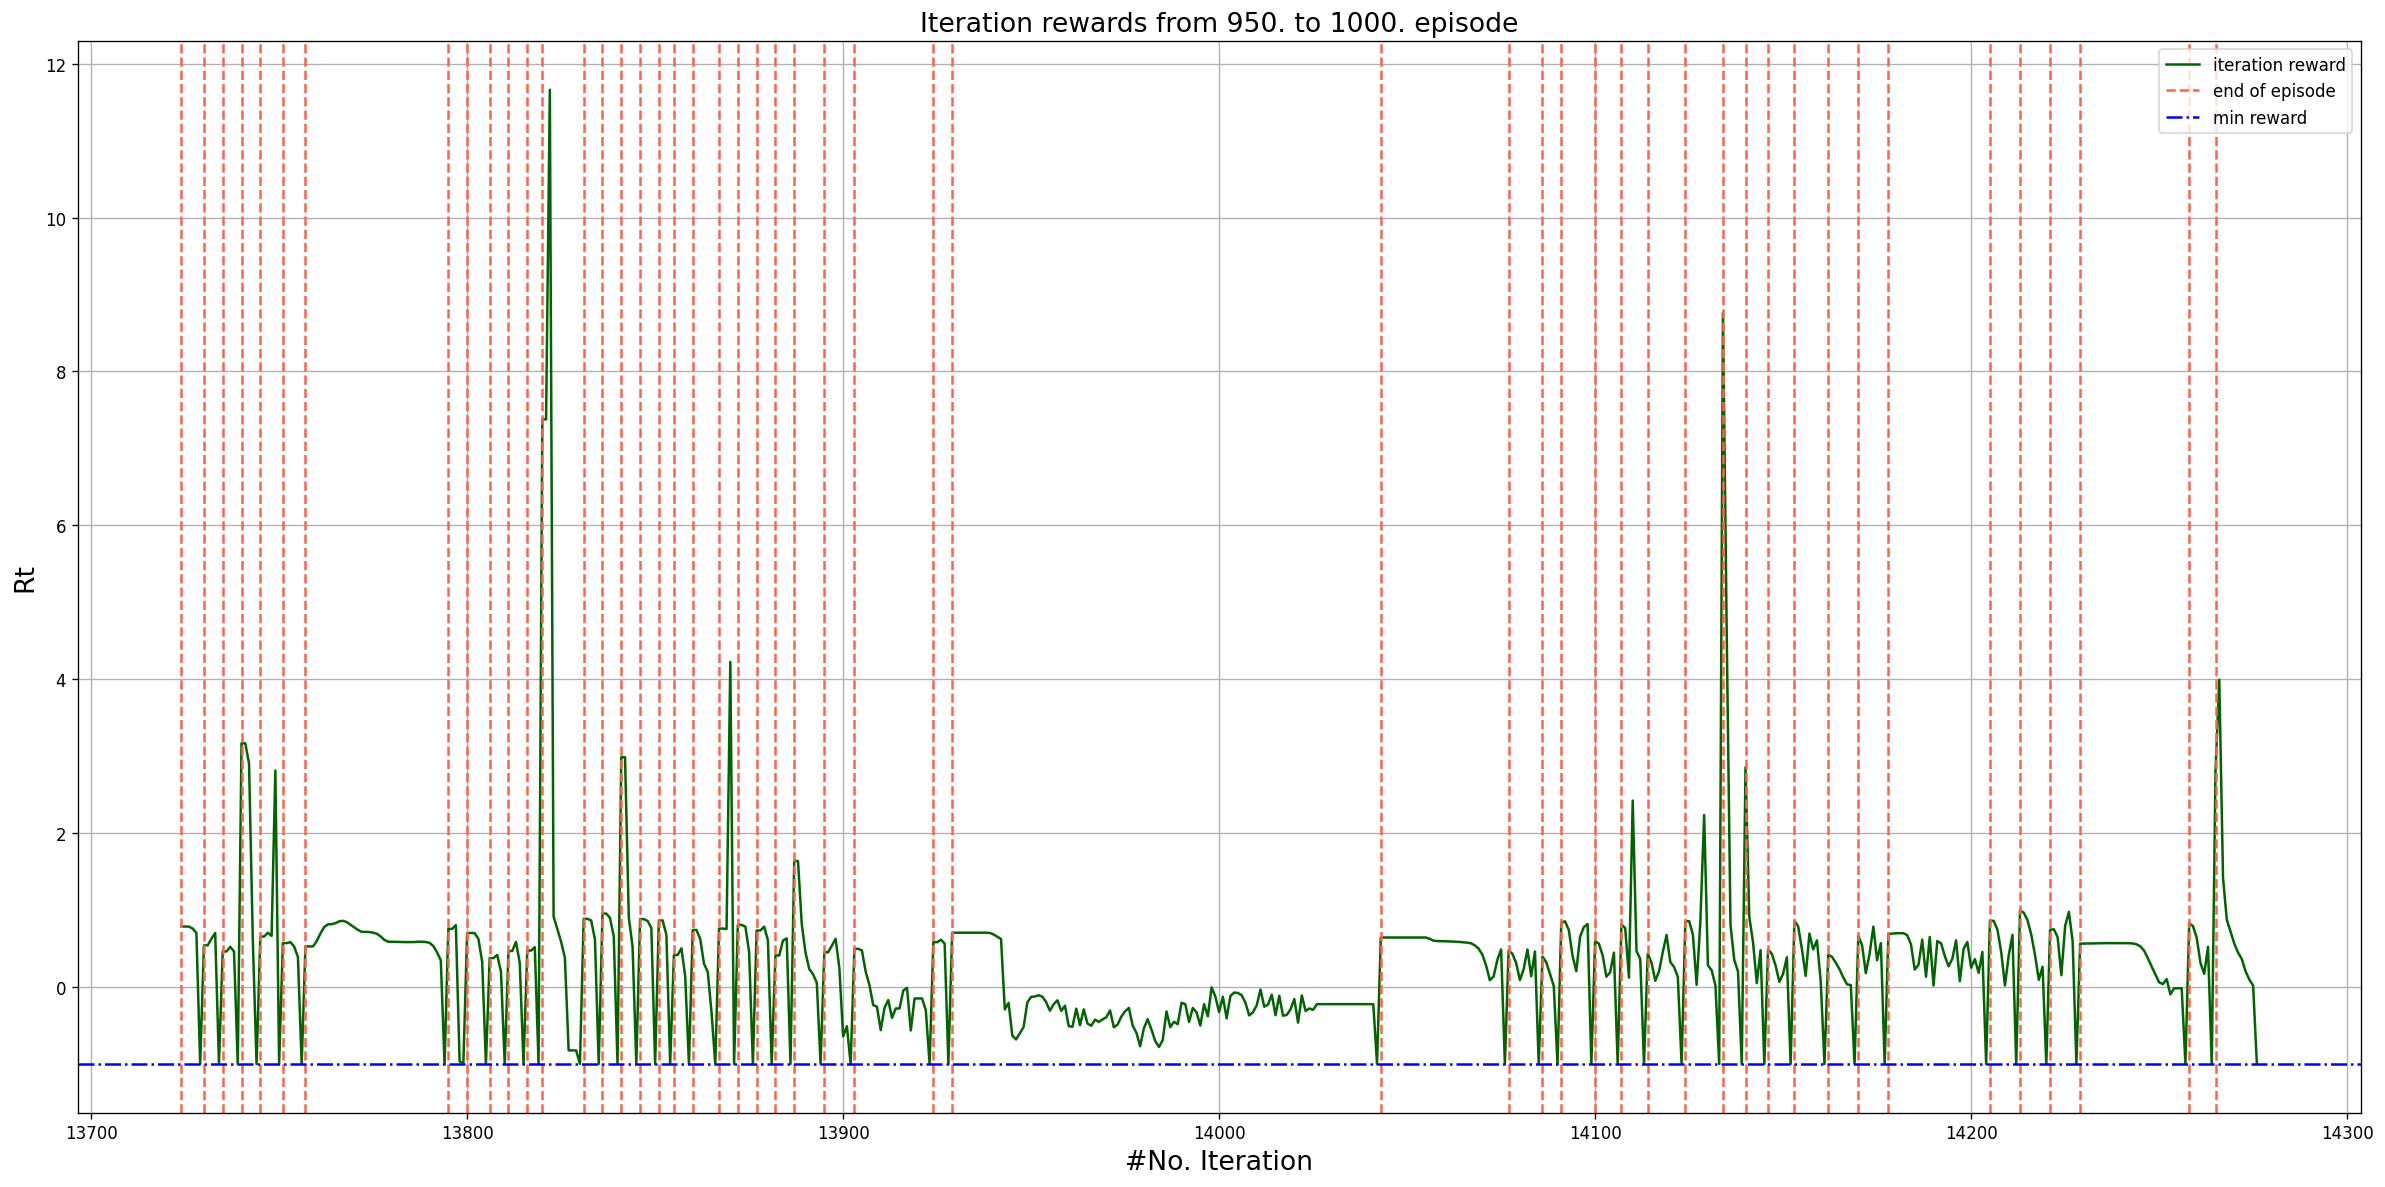

In [4]:
LEFT_INDEX = -51
RIGHT_INDEX = -1

left_index_for_title = LEFT_INDEX+1 if LEFT_INDEX >= 0 else TOTAL_EPISODES+LEFT_INDEX+1
right_index_for_title = RIGHT_INDEX+1 if RIGHT_INDEX >= 0 else TOTAL_EPISODES+RIGHT_INDEX+1

MIN_REWARD = -1.0

last_episodes_rewards = rewards[steps[LEFT_INDEX]:steps[RIGHT_INDEX]]

fig = plt.figure(figsize=(20,10), dpi=120)
plt.plot(np.arange(steps[LEFT_INDEX],steps[RIGHT_INDEX]), last_episodes_rewards, color='darkgreen', label='iteration reward')

for step in steps[LEFT_INDEX:RIGHT_INDEX]:
    if step == steps[RIGHT_INDEX-1]:
        plt.axvline(step,color='tomato', linestyle='--', label='end of episode')
    else:
        plt.axvline(step,color='tomato', linestyle='--')
    
plt.axhline(MIN_REWARD, color='blue', linestyle='-.', label='min reward')
plt.title('Iteration rewards from {:d}. to {:d}. episode'.format(left_index_for_title, right_index_for_title), fontsize=16)
plt.xlabel('#No. Iteration', fontsize=16)
plt.ylabel('Rt', fontsize=16)
plt.legend(loc='upper right')
plt.grid()

plt.tight_layout()
plt.show()

fig.savefig(IMAGES_PATH + training_name + '_iteration_rewards', facecolor = 'white', bbox_inches='tight')